<a href="https://colab.research.google.com/github/mkbahk/AmazonBraket/blob/main/005_External_Access_to_ClassicalAdder_AmazonBraket_with_qiskit_braket_provider_mkbahk_20241102_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 작업순서
1. Amazon Braket 환경 설정(확인만)
2. S3 환경설정(확인만)
3. (중요) IAM을 이용한 Access Key 설정 및 권한 부여
4. 원격 작업
5. 각종 로그 보기
6. 작업 환경 정리


In [1]:
#!pip install git+https://github.com/qiskit-community/qiskit-braket-provider.git

In [1]:
!pip install qiskit-braket-provider==0.7.0
!pip install amazon-braket-sdk==1.104.1
#!pip install amazon-braket-sdk==1.94.0
#!python3 -m pip install boto3
#!python3 -m pip install botocore

In [2]:
%pip show qiskit
%pip show qiskit-braket-provider
%pip show amazon-braket-sdk

Name: qiskit
Version: 2.2.3
Summary: An open-source SDK for working with quantum computers at the level of extended quantum circuits, operators, and primitives.
Home-page: https://www.ibm.com/quantum/qiskit
Author: 
Author-email: Qiskit Development Team <qiskit@us.ibm.com>
License: Apache 2.0
Location: /usr/local/lib/python3.12/dist-packages
Requires: dill, numpy, rustworkx, scipy, stevedore, typing-extensions
Required-by: qiskit-ionq, qiskit_braket_provider
Name: qiskit_braket_provider
Version: 0.7.0
Summary: Qiskit-Braket provider to execute Qiskit programs on AWS quantum computing hardware devices through Amazon Braket.
Home-page: 
Author: 
Author-email: 
License: 
Location: /usr/local/lib/python3.12/dist-packages
Requires: amazon-braket-sdk, certifi, numpy, qiskit, qiskit-ionq, setuptools
Required-by: 
Name: amazon-braket-sdk
Version: 1.104.1
Summary: An open source library for interacting with quantum computing devices on Amazon Braket
Home-page: https://github.com/amazon-braket/a

In [3]:
from braket.experimental_capabilities import EnableExperimentalCapability

In [4]:
# Use Braket SDK Cost Tracking to estimate the cost to run this example
from braket.tracking import Tracker
t = Tracker().start()

In [5]:
import os
# Set environment variables for AWS credentials
os.environ['AWS_ACCESS_KEY_ID'] = ""
os.environ['AWS_SECRET_ACCESS_KEY'] = ""
os.environ['AWS_DEFAULT_REGION'] = "us-east-1"

# You can optionally set the s3 bucket and prefix using environment variables
#os.environ['AWS_BRAKET_S3_BUCKET'] = "snuqc"
#os.environ['AWS_BRAKET_S3_PREFIX'] = "amazonbraket"

In [6]:
from qiskit_braket_provider import BraketLocalBackend

local_simulator = BraketLocalBackend()
#local_sv_simulator = BraketLocalBackend(name='braket_sv')
#local_dm_simulator = BraketLocalBackend(name='braket_dm')

In [7]:
from qiskit_braket_provider import BraketProvider

provider = BraketProvider()
#provider.backends(statuses=["ONLINE"], types=["SIMULATOR"])
#provider.backends(statuses=["ONLINE"], types=["QPU"])
provider.backends(statuses=["ONLINE"], types=["SIMULATOR", "QPU"])

[BraketBackend[Ankaa-3],
 BraketBackend[Emerald],
 BraketBackend[Forte 1],
 BraketBackend[Garnet],
 BraketBackend[SV1],
 BraketBackend[TN1],
 BraketBackend[dm1]]

In [8]:
#backend = provider.get_backend("Aria 1")
#backend = provider.get_backend("Aria 2")
#backend = provider.get_backend("Forte 1")

#backend= provider.get_backend("Ankaa-2")
#backend = provider.get_backend("Aspen-M-3")

#Ibackend = provider.get_backend("Garnet")

backend = provider.get_backend("SV1")
#backend = provider.get_backend("dm1")
#backend = provider.get_backend("TN1")

In [9]:
from qiskit import QuantumCircuit

##양자 회로 생성
qc = QuantumCircuit(5, 5)  # 5개의 양자 비트와 2개의 클래식 비트를 사용합니다.

# 입력 비트 설정 (A=1, B=1)
qc.x(0)  # A 비트를 1로 설정
qc.x(1)  # B 비트를 1로 설정
qc.barrier()

# 반-가산기 회로 구현
qc.cx(0, 3) # XOR 게이트 (A와 B의 논리합)
qc.cx(1, 3) # XOR 게이트 (A와 B의 논리합)
qc.ccx(0, 1, 4) # AND 게이트 (A와 B의 논리곱)
qc.cx(2, 3) # XOR 게이트 (A와 B의 논리합)
qc.ccx(0, 2, 4) # AND 게이트 (A와 B의 논리곱)
qc.ccx(1, 2, 4) # AND 게이트 (A와 B의 논리곱)
qc.barrier()

# 결과를 측정하여 Sum과 Carry 출력을 얻습니다.
qc.measure(0, 4)  # 큐비트를 클래식 비트 4에 매핑
qc.measure(1, 3)  # 큐비트를 클래식 비트 3에 매핑
qc.measure(2, 2)  # 보조비트를 클래식 비트 2에 매핑
qc.measure(3, 1)  # Sum(Result) 비트를 클래식 비트 1에 매핑
qc.measure(4, 0)  # Carry 비트를 클래식 비트 0에 매핑

In [10]:
qc.draw()

┌───┐ ░                                ░ ┌─┐            
q_0: ┤ X ├─░───■─────────■─────────■────────░─┤M├────────────
     ├───┤ ░   │         │         │        ░ └╥┘┌─┐         
q_1: ┤ X ├─░───┼────■────■─────────┼────■───░──╫─┤M├─────────
     └───┘ ░   │    │    │         │    │   ░  ║ └╥┘┌─┐      
q_2: ──────░───┼────┼────┼────■────■────■───░──╫──╫─┤M├──────
           ░ ┌─┴─┐┌─┴─┐  │  ┌─┴─┐  │    │   ░  ║  ║ └╥┘┌─┐   
q_3: ──────░─┤ X ├┤ X ├──┼──┤ X ├──┼────┼───░──╫──╫──╫─┤M├───
           ░ └───┘└───┘┌─┴─┐└───┘┌─┴─┐┌─┴─┐ ░  ║  ║  ║ └╥┘┌─┐
q_4: ──────░───────────┤ X ├─────┤ X ├┤ X ├─░──╫──╫──╫──╫─┤M├
           ░           └───┘     └───┘└───┘ ░  ║  ║  ║  ║ └╥┘
c: 5/══════════════════════════════════════════╩══╩══╩══╩══╩═
                                               4  3  2  1  0

In [12]:
from qiskit.compiler import transpile
trans_qc = transpile(qc, backend)
trans_qc.draw()

┌───┐ ░                                ░             ┌─┐
q_0: ┤ X ├─░───■─────────■─────────■────────░─────────────┤M├
     ├───┤ ░   │         │         │        ░          ┌─┐└╥┘
q_1: ┤ X ├─░───┼────■────■─────────┼────■───░──────────┤M├─╫─
     └───┘ ░   │    │    │         │    │   ░       ┌─┐└╥┘ ║ 
q_2: ──────░───┼────┼────┼────■────■────■───░───────┤M├─╫──╫─
           ░ ┌─┴─┐┌─┴─┐  │  ┌─┴─┐  │    │   ░    ┌─┐└╥┘ ║  ║ 
q_3: ──────░─┤ X ├┤ X ├──┼──┤ X ├──┼────┼───░────┤M├─╫──╫──╫─
           ░ └───┘└───┘┌─┴─┐└───┘┌─┴─┐┌─┴─┐ ░ ┌─┐└╥┘ ║  ║  ║ 
q_4: ──────░───────────┤ X ├─────┤ X ├┤ X ├─░─┤M├─╫──╫──╫──╫─
           ░           └───┘     └───┘└───┘ ░ └╥┘ ║  ║  ║  ║ 
c: 5/══════════════════════════════════════════╩══╩══╩══╩══╩═
                                               0  1  2  3  4

In [13]:
from qiskit.providers.jobstatus import JobStatus
import time

job = backend.run(trans_qc, shots=1024)

print("Job ID is", job.job_id(),"\n")

# 제출된 잡에 대한 지속적인 실행 상태 확인
#while job.status() is not JobStatus.DONE:
#	print("Job status is", job.status() )
#	time.sleep(2)
###while

/usr/local/lib/python3.12/dist-packages/qiskit_braket_provider/providers/adapter.py:593: UserWarning: The Qiskit circuit contains barrier instructions that are ignored.
  warnings.warn("The Qiskit circuit contains barrier instructions that are ignored.")


Job ID is arn:aws:braket:us-east-1:772420518916:quantum-task/4e8f6a79-b38c-41f2-8851-6a8a5fcc3579 



In [14]:
print("Job status is", job.status() )

Job status is JobStatus.DONE


In [15]:
# 중간에 세션이 종료된 경우 기존에 실행이 완료된 Job을 복구하는 방법
#job = backend.retrieve_job("arn:aws:braket:us-east-1:746669231099:quantum-task/f6fab6be-1590-4da0-914a-fade74efc485")

In [16]:
result = job.result()
result

Result(backend_name='SV1', backend_version='2', job_id='arn:aws:braket:us-east-1:772420518916:quantum-task/4e8f6a79-b38c-41f2-8851-6a8a5fcc3579', success=True, results=[ExperimentResult(shots=1024, success=True, meas_level=2, data=ExperimentResultData(counts={'10011': 1024}, memory=['10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '1001

In [17]:
# 결과 출력
counts = result.get_counts()
print(counts)

{'10011': 1024}


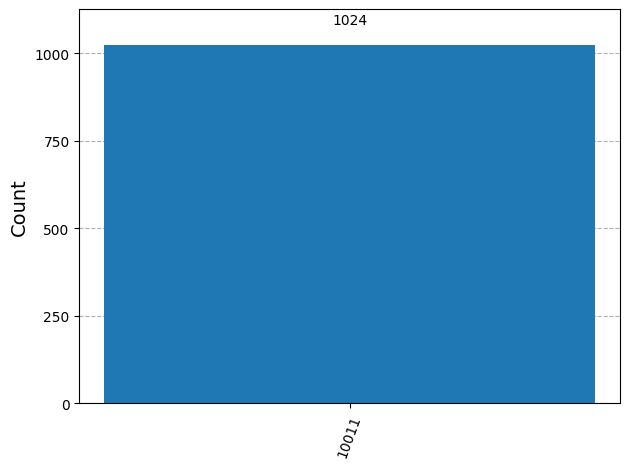

In [18]:
from qiskit.visualization import plot_histogram
plot_histogram(data=counts)

In [19]:
print("Quantum Task Summary\n")
print(t.quantum_tasks_statistics())
print('\nNote: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. \nEstimated charges shown may differ from your actual charges. \nEstimated charges do not factor in any discounts or credits, \nand you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).')
print(f"\nEstimated cost to run this example: {t.qpu_tasks_cost() + t.simulator_tasks_cost():.2f} USD")

Quantum Task Summary

{'arn:aws:braket:::device/quantum-simulator/amazon/sv1': {'shots': 1024, 'tasks': {'COMPLETED': 1}, 'execution_duration': datetime.timedelta(microseconds=4000), 'billed_execution_duration': datetime.timedelta(seconds=3)}}

Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. 
Estimated charges shown may differ from your actual charges. 
Estimated charges do not factor in any discounts or credits, 
and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).

Estimated cost to run this example: 0.00 USD
